In [1]:
%matplotlib widget

In [2]:
import edrixs 
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import io
import sys
from ana_functions import *
from scipy.signal import find_peaks

%matplotlib widget

Confirm consistency of new function, in which transitions have specifically specified width, and original EDRIXS

edrixs >>> Running ED ...

    Summary of Slater integrals:
    ------------------------------
    Terms,   Initial Hamiltonian,  Intermediate Hamiltonian
     F0_vv :          0.0000000000        0.0000000000
     F2_vv :          0.0000000000        0.0000000000
     F4_vv :          0.0000000000        0.0000000000
     F0_vc :          0.0000000000        0.0000000000
     F2_vc :          0.0000000000        0.0000000000
     G1_vc :          0.0000000000        0.0000000000
     G3_vc :          0.0000000000        0.0000000000
     F0_cc :          0.0000000000        0.0000000000
     F2_cc :          0.0000000000        0.0000000000

edrixs >>> Dimension of the initial Hamiltonian:  10
edrixs >>> Dimension of the intermediate Hamiltonian:  4
edrixs >>> Building Many-body Hamiltonians ...
edrixs >>> Done !
edrixs >>> Exact Diagonalization of Hamiltonians ...
edrixs >>> Done !
edrixs >>> ED Done !
edrixs >>> Running XAS ...
edrixs >>> XAS Done !
edrixs >>> Running RIXS ... 
edri

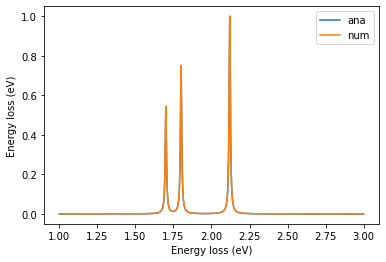

In [3]:
Ez2 = 1.7 # 1.7
Exy = 1.8
Ezx = 2.12 #2.12

Wz2 = 0.01
Wxy = 0.01
Wx2y2 = 0.01
Wzx = 0.01

J = .130*0

res = 1e-9

alpha = np.pi/2 # rad
thin = 45       # deg
thout = 45     # deg
phi = 0        # deg

eloss = np.linspace(1, 3, 1000000)

orbital_index_i = 3
spin_index_i = 0

Iana = get_RIXS(eloss,
             Ez2=Ez2, Ezx=Ezx, Exy=Exy,
             Wz2=Wz2, Wzx=Wzx, Wxy=Wxy,
             J=J, res=res,
             I0=1,
             thin=thin, thout=thout, phi=phi,
             alpha=alpha,
             select=range(5))

# Standard EDRIXS here
pol_type_rixs = [('linear', alpha, 'linear', 0), ('linear', alpha, 'linear', np.pi/2)]

shell_name = ('d', 'p32')
v_noccu = 9
off = 931

ext_B = np.array([1e-4, 1e-4, 0])
temperature = 1e-9

# d3z2-r2 dzx dzy dx2-y2 dxy
tmp = np.array([-en for dd in [Ez2, Ezx, Ezx, 0, Exy] for en in [dd]*2])
v_cfmat = edrixs.cb_op(np.diag(tmp), edrixs.tmat_r2c('d', ispin=True))

info = edrixs.utils.get_atom_data('Cu', '3d', v_noccu, edge='L3')
v_soc = None
c_soc = info['c_soc']


out = edrixs.ed_1v1c_py(shell_name, shell_level=(0, -off), v_soc=v_soc,
                        c_soc=c_soc, v_noccu=v_noccu,
                        ext_B=ext_B, on_which='spin', v_cfmat=v_cfmat)
eval_i, eval_n, trans_op = out

ominc = np.linspace(925, 935, 2000)

xas = edrixs.xas_1v1c_py(
    eval_i, eval_n, trans_op, ominc, gamma_c=info['gamma_c'],
    thin=0, phi=0, pol_type=[('isotropic', 0)])

res_energy = ominc[np.argmax(xas[:, 0])]
assert res_energy > 926
assert res_energy < 934

                    #(x, center, amplitude, width, offset)
gamma_f = Wz2/2 # lorentzian HWHM

rixs = edrixs.rixs_1v1c_py(
    eval_i, eval_n, trans_op, [res_energy], eloss,
    gamma_c=info['gamma_c'], gamma_f=gamma_f,
    thin=thin*np.pi/180, thout=thout*np.pi/180, phi=phi*np.pi/180,
    pol_type=pol_type_rixs, gs_list=[0, 1],
    temperature=temperature
    )

I_num=rixs.sum((0, 2))

fig, ax = plt.subplots()

ax.plot(eloss, Iana/Iana.max(), label='ana')
ax.plot(eloss, I_num/I_num.max(), label='num')
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('Energy loss (eV)')
ax.legend()

In [4]:
indices = find_peaks(Iana/Iana.max(), height=.1)
indices

(array([350000, 399999, 559999]),
 {'peak_heights': array([0.54356914, 0.75141954, 1.        ])})

Why is this not the same as [M. Moretti et al., New Journal of Physics 13, 043026 (2011)](https://iopscience.iop.org/article/10.1088/1367-2630/13/4/043026/pdf) Fig. 4?
The very small peak in the Moretti plot comes from an orbital-dependent exchange splitting that cannot easily be put into standard edixs, but which is not the source of the discrepancy.

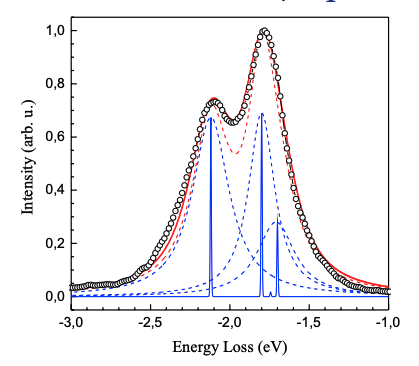

In [5]:
from IPython.display import Image
Image(filename='moretti.png') 